In [12]:
import matplotlib.pyplot as plt
from PyAstronomy import pyasl

from NEID_solar_functions import *
from GP_kernels import *

import celerite
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from datetime import datetime
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import random
from scipy.signal import hilbert, chirp


# Can GP be recovered?

In [13]:
def gp_recovery(data_gp, model_gp):
   
    # generate mock data
    t = np.arange(N)/10
    yerr = np.random.uniform(0.05, 0.25, N)
    data_gp.compute(t, yerr)
    y = data_gp.sample()
   
    plt.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(18, 4))
    
    
    # RV
    _, t_train, y_train, yerr_train, t_test, y_test, yerr_test = random_ts(t, y, yerr, test_ratio=0.07)
    plt.plot(t, y, '.', alpha=0.3, label='full data')
    plt.xlabel('t [min]')
    plt.ylabel('RV [m/s]')
    plt.errorbar(t_test, y_test, yerr_test, fmt="ro", capsize=0, alpha=0.5, label='data sample')   
    
    gp = model_gp(t_test, y_test, yerr_test)
    pred_y, pred_var = gp.predict(y_test, t, return_var=True)
    pred_std = np.sqrt(pred_var)
    plt.fill_between(t, pred_y+pred_std, pred_y-pred_std, color='orange', alpha=0.5,
                     edgecolor="none")
    plt.plot(t, pred_y, 'orange', label='gp prediction')    
    plt.legend()

    analytic_signal = hilbert(y)
    amplitude_envelope_1 = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_period_1 = (2.0*np.pi) / (np.diff(instantaneous_phase) * 10)
    plt.plot(t, amplitude_envelope_1, 'b', label='envelope_full_data')
    plt.plot(t, -amplitude_envelope_1, 'b')

    analytic_signal = hilbert(pred_y)
    amplitude_envelope_2 = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_period_2 = (2.0*np.pi) / (np.diff(instantaneous_phase) * 10)
    plt.plot(t, amplitude_envelope_2, 'm', label='envelope_gp_pred')
    plt.plot(t, -amplitude_envelope_2, 'm')

    plt.show()


    # residual 
    fig = plt.figure(figsize=(18, 1))
    plt.plot(t, pred_y-y, 'k.', alpha=0.2)
    plt.xlabel('t [min]')
    plt.ylabel('Residual')
    plt.show()


    # Periodogram 1
    fig = plt.figure(figsize=(18, 3))

    frequency, power = LombScargle(t, y, yerr).autopower(maximum_frequency=1, samples_per_peak=10)        
    plot_x = 1/frequency
    idx = (plot_x<200) 
    plt.plot(plot_x[idx], power[idx], alpha=0.8, label='full data')

    frequency, power = LombScargle(t_test, y_test, yerr_test).autopower(maximum_frequency=1, samples_per_peak=10)        
    plot_x = 1/frequency
    idx = (plot_x<200) 
    plt.plot(plot_x[idx], power[idx], 'r', alpha=0.1, label='data sample')

    frequency, power = LombScargle(t, pred_y, yerr).autopower(maximum_frequency=1, samples_per_peak=10)        
    plot_x = 1/frequency
    idx = (plot_x<200) 
    plt.plot(plot_x[idx], power[idx], 'orange', alpha=0.8, label='gp prediction')

    frequency, power = LombScargle(t, pred_y-y, yerr).autopower(maximum_frequency=1, samples_per_peak=10)        
    plot_x = 1/frequency
    idx = (plot_x<200) 
    plt.plot(plot_x[idx], power[idx], 'k', alpha=0.5, label='residual [m/s]')    
    
    plt.title('Time-series periodogram')
    plt.ylabel('Power')
    plt.xlabel('Period [min]')
    plt.xscale('log')
    plt.legend(loc=5)
    plt.show()     


    # Periodogram 2
    fig = plt.figure(figsize=(18, 3))

    frequency, power = LombScargle(t, amplitude_envelope_1).autopower(maximum_frequency=1, samples_per_peak=10)        
    plot_x = 1/frequency
    idx = (plot_x<200) 
    plt.plot(plot_x[idx], power[idx], alpha=0.8, label='data envelope')

    frequency, power = LombScargle(t, amplitude_envelope_2).autopower(maximum_frequency=1, samples_per_peak=10)        
    plot_x = 1/frequency
    idx = (plot_x<200) 
    plt.plot(plot_x[idx], power[idx], alpha=0.8, label='gp prediction envelope')
    
    plt.title('Envelope periodogram')
    plt.ylabel('Power')
    plt.xlabel('Period [min]')
    plt.xscale('log')
    plt.legend()
    plt.show()        
    
    # instantaneous period
    fig = plt.figure(figsize=(18, 2))
    plt.plot(t[1:], instantaneous_period_1, 'b', label='of data')
    plt.plot(t[1:], instantaneous_period_2, 'orange', label='of gp prediction')
    plt.xlabel('t [min]')
    plt.ylabel('instantaneous period [min]')
    plt.ylim(0, 10)
    plt.legend()
    plt.show()

    
    print('Recovered parameters:')
    od = gp.get_parameter_dict()
    for key, value in od.items():
        print(key[11:], '\t:', np.exp(value))    

    print('\nfull data wrms = {:.3f}'.format(np.average(y**2, weights=1/yerr**2)**0.5))
    print('residual wrms = {:.3f}'.format(np.average((pred_y-y)**2, weights=1/yerr**2)**0.5))    
    
    return gp


Play with Q and test_ratio, noise

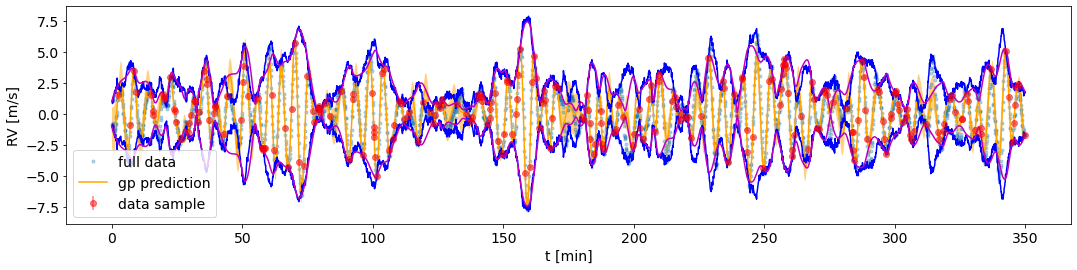

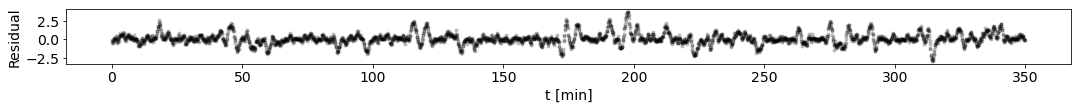

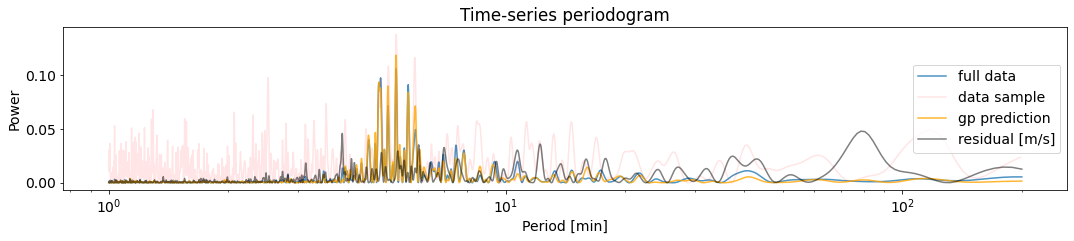

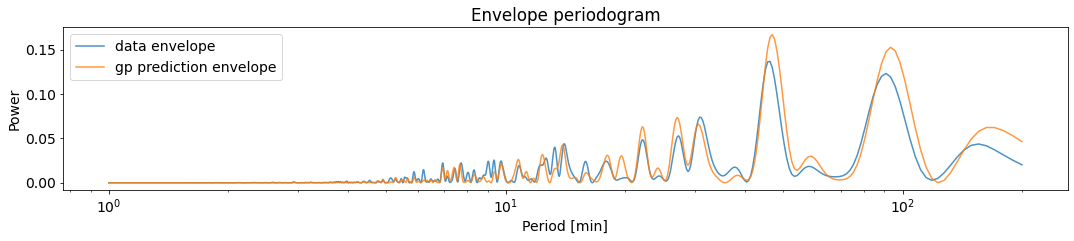

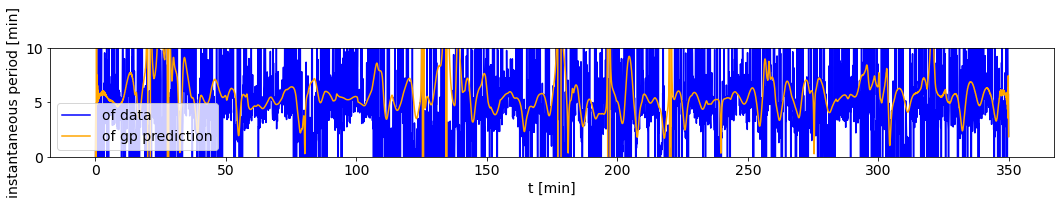

Recovered parameters:
S0 	: 0.9862326005369032
Q 	: 4.0337587360435725
omega0 	: 1.226855206132742

full data wrms = 2.160
residual wrms = 0.751


In [14]:
S0 = 1
Q = 5
w0 = 1.194540843699886
N = 3500

kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0))
data_gp = celerite.GP(kernel)

def model_gp(t, y, yerr):
    w0 = 2*np.pi/5
    Q = 10
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp

gp = gp_recovery(data_gp, model_gp)


### 2 modes; wrong model

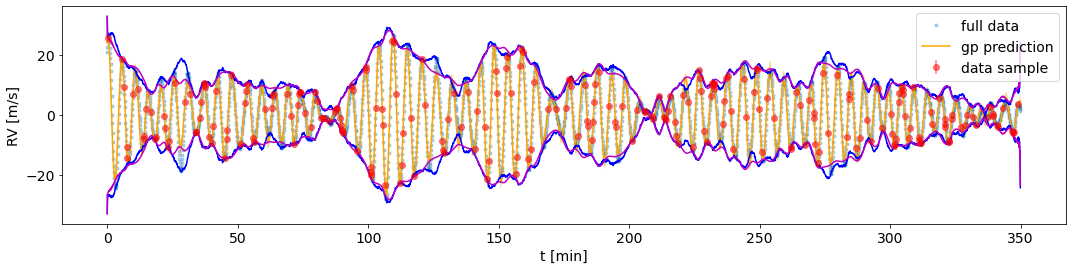

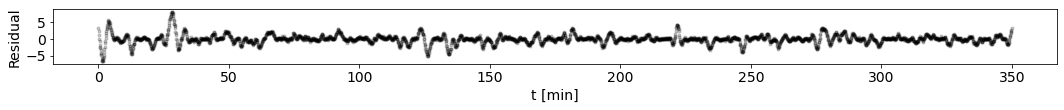

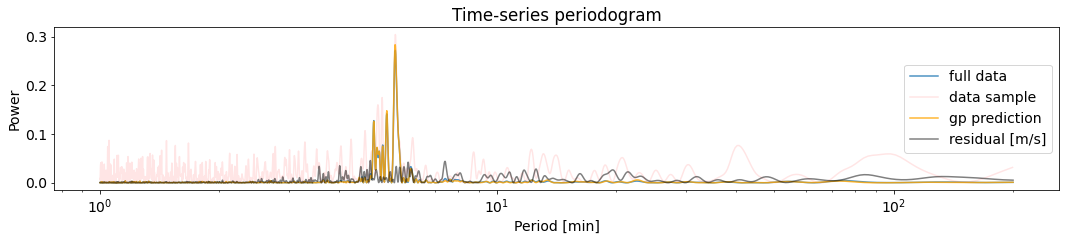

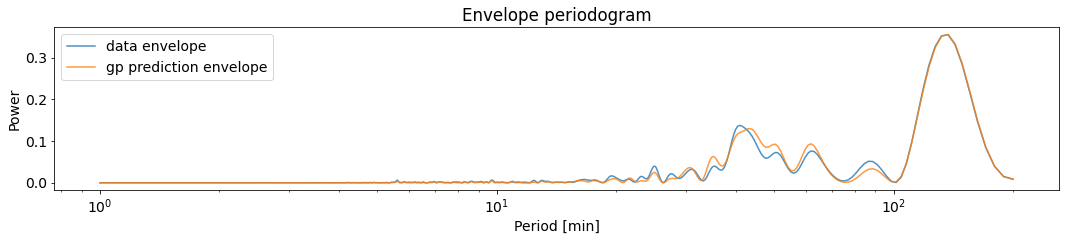

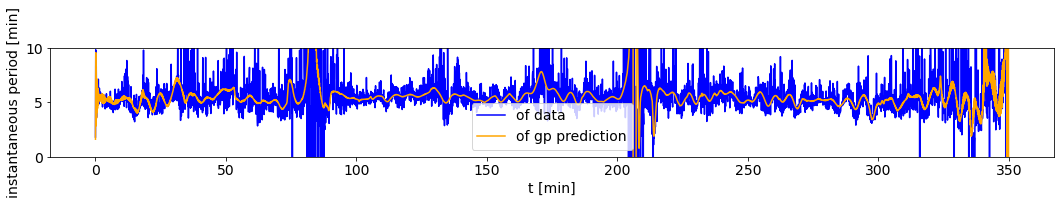

Recovered parameters:
S0 	: 2.6883751724923783
Q 	: 31.33916551578885
omega0 	: 1.1823138501297317

full data wrms = 9.602
residual wrms = 1.364


In [15]:
S0 = 1
Q = 100
N = 3500

t = np.arange(N)/10
yerr = np.random.uniform(0.01, 0.05, N)

k1 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3033.754e-6/60)))
k2 = terms.SHOTerm(log_S0=np.log(S0+0.1), log_Q=np.log(Q-2), log_omega0=np.log(2*np.pi/(1/3303.520e-6/60)))   
kernel = k1 + k2
data_gp = celerite.GP(kernel)

def model_gp(t, y, yerr):
    w0 = 2*np.pi/5
    Q = 10
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp

gp = gp_recovery(data_gp, model_gp)

In [16]:
2*np.pi/np.exp(gp.get_parameter('kernel:log_omega0'))

5.314312529190241

In [17]:
1/3033.754e-6/60, 1/3303.520e-6/60

(5.493743614896483, 5.045123585347347)

### 2 modes; right model

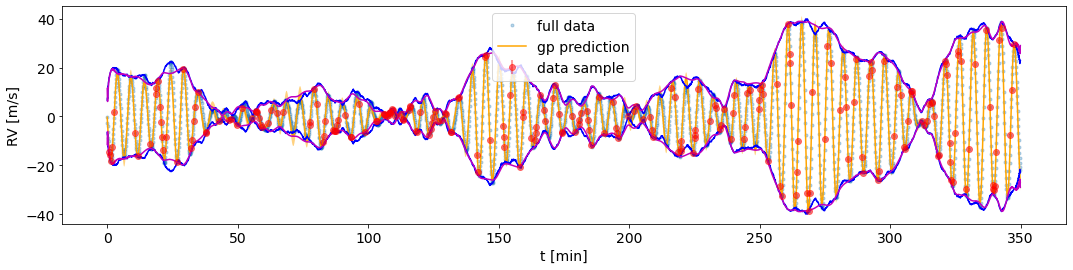

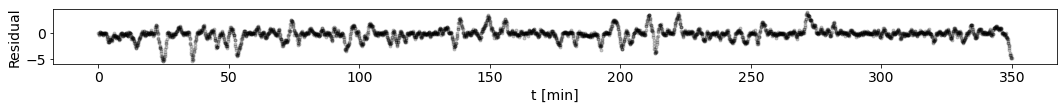

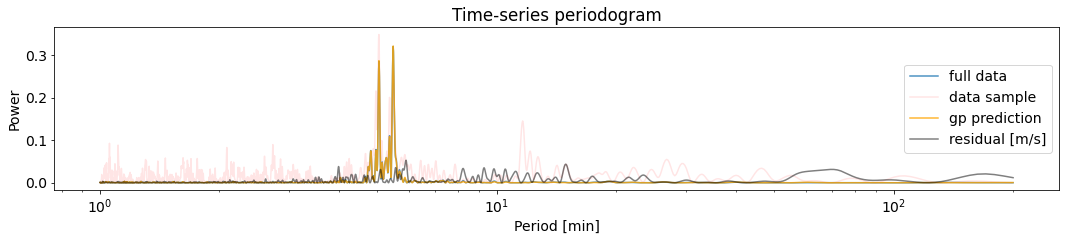

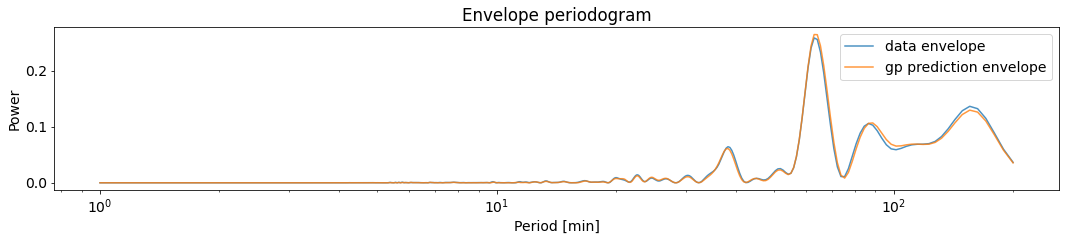

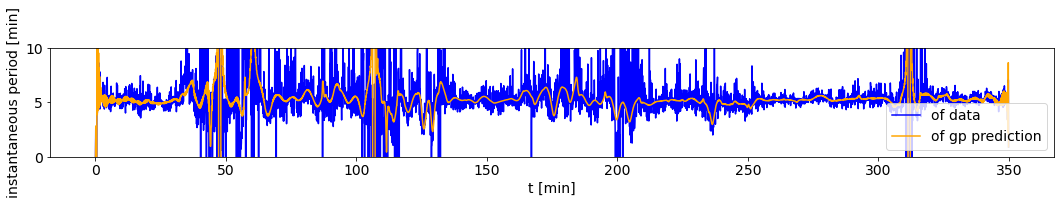

Recovered parameters:
s[0]:log_S0 	: 28.12166468530718
s[0]:log_Q 	: 52.26547907079098
s[0]:log_omega0 	: 0.0009921595982248855
s[1]:log_S0 	: 3.097457704516563
s[1]:log_Q 	: 51.41664905169579
s[1]:log_omega0 	: 1.2033258998410834

full data wrms = 12.649
residual wrms = 1.133


In [18]:
def model_gp(t, y, yerr):
    w0 = 2*np.pi/5
    Q = 10
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
    k1 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)
    k2 = terms.SHOTerm(log_S0=np.log(S0+0.5), log_Q=np.log(Q+10), log_omega0=np.log(w0), bounds=bounds)
    kernel = k1 + k2
    
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp

gp = gp_recovery(data_gp, model_gp)

In [19]:
2*np.pi/np.exp(gp.get_parameter('kernel:terms[0]:log_omega0')), 2*np.pi/np.exp(gp.get_parameter('kernel:terms[1]:log_omega0'))

(6332.837295956314, 5.221515890258301)

# Example: Amplitude evelope 

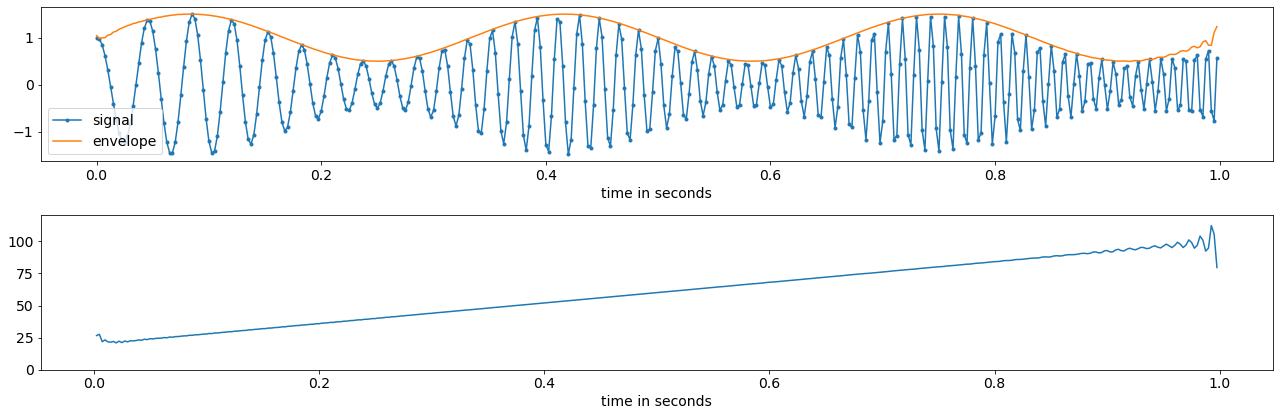

In [20]:

duration = 1.0
fs = 400.0
samples = int(fs*duration)
t = np.arange(samples) / fs

signal = chirp(t, 20.0, t[-1], 100.0)
signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )

analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * fs)

fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(18, 6))

ax0.plot(t, signal, '.-', label='signal')
ax0.plot(t, amplitude_envelope, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()
ax1.plot(t[1:], instantaneous_frequency)
ax1.set_xlabel("time in seconds")
ax1.set_ylim(0.0, 120.0)
fig.tight_layout()
plt.show()

In [21]:
signal.shape

(400,)

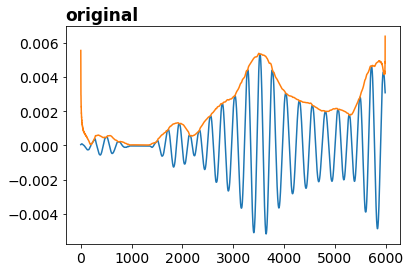

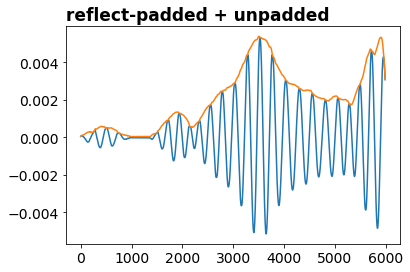

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft

def analytic(x):
    N = len(x)
    xf = fft(x)
    xf[1:N//2] *= 2
    if N % 2 == 1:
        xf[N//2] *= 2
    xf[N//2 + 1:] = 0
    xa = ifft(xf)
    assert np.allclose(xa.real, x)
    return xa

def plot(x, title=None, show=0):
    plt.plot(x)
    if title is not None:
        plt.title(title, loc='left', weight='bold', fontsize=17)
    if show:
        plt.show()

#%%###########################################################################
# load
x = np.load('data.npy')
N = len(x)
xa = analytic(x)

# pad + take hilbert
xp = np.pad(x, N, mode='reflect')
xpa = analytic(xp)
# unpad
xpu = xp[N:-N]
xpau = xpa[N:-N]

#%% visualize
plot(x, title="original")
plot(np.abs(xa), show=1)

plot(xpu, title="reflect-padded + unpadded")
plot(np.abs(xpau), show=1)